In [1]:
import joblib, argparse, uuid, sigopt
import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit import DataStructs
from sklearn import preprocessing
from utils.sklearn_utils import *
import matplotlib.pyplot as plt
import seaborn as sns

import selfies as sf
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers,regularizers


gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)

    except RuntimeError as e:
        print(e)

/home/santiagovargas/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/santiagovargas/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/santiagovargas/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/

In [2]:
# Used to convert molecules to string representation

from utils.selfies_util import selfies,smile_to_hot, \
multiple_smile_to_hot, selfies_to_hot, multiple_selfies_to_hot,\
get_selfie_and_smiles_encodings_for_dataset, compare_equality, tanimoto_dist

In [3]:
# previously implemented extraction script from a database of quinones we gathered
# names are strings in the smiles format
names, ret, homo, homo1, diff = selfies()
print(len(names))

..........converting xyz to smiles.......
 55026 / 61182

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 57376 / 61182

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 59904 / 61182

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 61178 /6118058183
58183
58183
58183
58183
58183


In [4]:
# convert from smiles to selfies (different formats)

selfies_list, selfies_alphabet, largest_selfies_len,\
smiles_list, smiles_alphabet, largest_smiles_len\
= get_selfie_and_smiles_encodings_for_dataset(names)

data = multiple_selfies_to_hot(selfies_list, largest_selfies_len,\
                                       selfies_alphabet)

max_mol_len = data.shape[1]
alpha_len = data.shape[2]
len_alphabet_mol = alpha_len * max_mol_len

--> Translating SMILES to SELFIES...
Finished translating SMILES to SELFIES.


In [5]:
print(np.shape(data))

(58183, 60, 30)


# NN Autoencoder

In [6]:
# simple autoencoder --------------------------

#encoder
data_reshape = data.reshape(data.shape[0], data.shape[1] * data.shape[2])
x_train = data_reshape[0:int(data.shape[0] * 0.8)]
x_test = data_reshape[int(data.shape[0] * 0.8):-1]

print("data per sample: "+ str(data.shape[1] * data.shape[2]))
latent_dim = 64

encoder_inputs = keras.Input(shape=(data.shape[1] *  data.shape[2]* 1))
# encode
x = layers.Dense(128, activation='relu')(encoder_inputs)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dense(128, activation='relu')(x)

#hidden
x = layers.Dense(latent_dim, activation= "relu")(x)
#decode
x = layers.Dense(128, activation='relu')(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dense(128, activation='relu')(x)

decoded = layers.Dense(1800, activation='sigmoid')(x)
model = keras.Model(encoder_inputs, decoded)

model.compile(optimizer=keras.optimizers.Adam(), loss = "MSE")
model.summary()
history = model.fit(x_train, x_train, epochs=40, batch_size = 64,
                   validation_data=(x_test, x_test))

data per sample: 1800
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1800)]            0         
_________________________________________________________________
dense (Dense)                (None, 128)               230528    
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_4 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_5 (Dense)              (No

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1800)]            0         
_________________________________________________________________
dense (Dense)                (None, 128)               230528    
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_4 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_5 (Dense)              (None, 128)              

Text(0.5, 1.0, 'NN Autoencoder Training Loss')

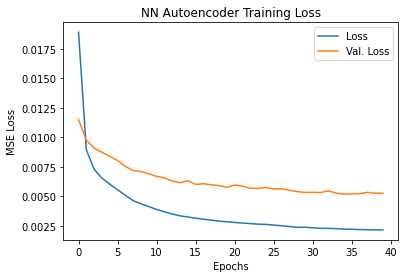

In [7]:
# Encoder component extracted 
model.summary()

x_test = data_reshape[int(data.shape[0] * 0.8):-1]

#earlyPredictor = keras.Model(\
#    model.inputs,model.get_layer("dense_50").output)
# use compress rep to make another neural network to predict energy
#compress_rep = earlyPredictor.predict(x_test)


import matplotlib.pyplot as plt 
plt.plot(history.history["loss"], label = "Loss")
plt.plot(history.history["val_loss"], label= "Val. Loss")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.title("NN Autoencoder Training Loss")

In [8]:
# Reconstruction Accuracy Test


################### AUTOENCODER TEST SCRIPTS

encode_self = sf.encoder(names[10])
decoded_smiles = sf.decoder(encode_self)
#print(decoded_smiles)

# full dataset
autoencode_out = model.predict(x_test)
autoencode_out_reshape = autoencode_out.reshape((len(x_test), data.shape[1], data.shape[2]))


# single point - through vae
one_hot = np.zeros((data.shape[1], data.shape[2]))
#print(np.shape(one_hot))
for i,j  in enumerate(autoencode_out_reshape[10]):
    lab_temp = np.argmax(j)
    one_hot[i][lab_temp] = 1
autoencode_out = autoencode_out_reshape

#single point - non vae
one_hot_true = np.zeros((data.shape[1], data.shape[2]))
for i,j  in enumerate(x_test[10].reshape(data.shape[1], data.shape[2])):
    lab_temp = np.argmax(j)
    one_hot_true[i][lab_temp] = 1

       

# single point - test data
self_test = sf.encoding_to_selfies(one_hot.tolist(), selfies_alphabet, "one_hot")
self_true = sf.encoding_to_selfies(one_hot_true.tolist(), selfies_alphabet, "one_hot")

smile_test = sf.decoder(self_test)
smile_true = sf.decoder(self_true)

################### AUTOENCODER TEST SCRIPTS - Full test script
compare_equality(x_test.reshape(x_test.shape[0], data.shape[1], data.shape[2]), autoencode_out_reshape, (data.shape[1], data.shape[2]), selfies_alphabet)




Autoencoded Smiles: CCc1c([O])c(N(O)O)c(NC)c([O])c1Cc1ccccc1
True Smiles: COc1c([O])c(Cc2ccccc2)c(CO)c([O])c1N(O)O
Percent Reconstructed Molescules: 0.00266414575455483


Text(0.5, 0, 'Similarity (Higher is Better)')

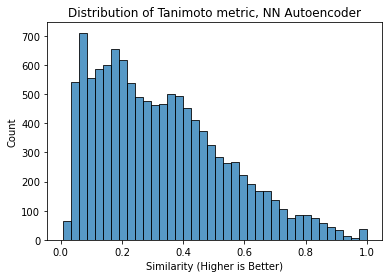

In [9]:
dist = tanimoto_dist(
    x_test.reshape(x_test.shape[0], data.shape[1], data.shape[2]), 
    autoencode_out_reshape, (data.shape[1], data.shape[2]), 
    selfies_alphabet)

sns.histplot(dist)
plt.title("Distribution of Tanimoto metric, NN Autoencoder")
plt.ylabel("Count")
plt.xlabel("Similarity (Higher is Better)")

# LTSM Autoencoder

In [10]:
# LSTM Auto encoder

print(data.shape)
#print(data[0])

data_reshape = data.reshape(data.shape[0], data.shape[1] * data.shape[2])
x_train = data[0:int(data.shape[0] * 0.8)]
x_test = data[int(data.shape[0] * 0.8):-1]

timesteps = data.shape[1]
input_dim = data.shape[2]
latent_dim = 64


inputs = keras.Input(shape=(timesteps, input_dim))

encoded = layers.LSTM(512,return_sequences=True)(inputs)
encoded = layers.LSTM(128,return_sequences=True)(encoded)
encoder = layers.LSTM(latent_dim,return_sequences=True)(encoded)

# batch norm??
decoded = layers.LSTM(128,return_sequences=True)(encoder)
decoded = layers.LSTM(512,return_sequences=True)(decoded)
decoder = layers.LSTM(input_dim, return_sequences=True)(encoded)

sequence_autoencoder = keras.Model(inputs, decoder)
encoder = keras.Model(inputs, encoded)



sequence_autoencoder.compile(optimizer=keras.optimizers.Adam(), 
                             loss = "mse",
                            metrics=[tf.keras.metrics.RootMeanSquaredError()])
sequence_autoencoder.summary()

history = sequence_autoencoder.fit(x_train, x_train, epochs=15, batch_size=512, 
                   validation_data=(x_test, x_test))

(58183, 60, 30)
Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 60, 30)]          0         
_________________________________________________________________
lstm (LSTM)                  (None, 60, 512)           1112064   
_________________________________________________________________
lstm_1 (LSTM)                (None, 60, 128)           328192    
_________________________________________________________________
lstm_5 (LSTM)                (None, 60, 30)            19080     
Total params: 1,459,336
Trainable params: 1,459,336
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
91/91 [==============================] - 6s 61ms/step - loss: 0.0202 - root_mean_squared_error: 0.1420 - val_loss: 0.0170 - val_root_mean_squared_error: 0.1302
Epoch 2/15
91/91 [==============================] - 5s 

Text(0.5, 1.0, 'LTSM Autoencoder Training Loss')

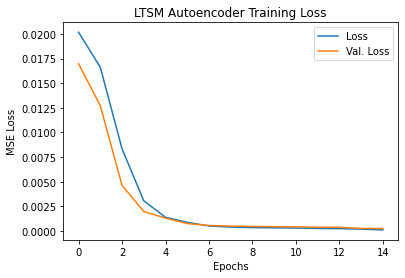

In [11]:
import matplotlib.pyplot as plt 
plt.plot(history.history["loss"], label = "Loss")
plt.plot(history.history["val_loss"], label= "Val. Loss")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.title("LTSM Autoencoder Training Loss")

In [12]:
autoencode_out = sequence_autoencoder.predict(x_test)
autoencode_out_reshape = autoencode_out.reshape((len(x_test), data.shape[1], data.shape[2]))
################### AUTOENCODER TEST SCRIPTS - Full test script
print(np.shape(x_test.reshape(x_test.shape[0], data.shape[1], data.shape[2])))
print(np.shape(autoencode_out_reshape))
compare_equality(x_test.reshape(x_test.shape[0], data.shape[1], data.shape[2]), autoencode_out_reshape, 
                 (data.shape[1], data.shape[2]), selfies_alphabet)

(11636, 60, 30)
(11636, 60, 30)
Autoencoded Smiles: COc1c([O])c(Cc2ccccc2)c(CO)c([O])c1N(O)O
True Smiles: COc1c([O])c(Cc2ccccc2)c(CO)c([O])c1N(O)O
Percent Reconstructed Molescules: 0.8058611206600206


Text(0.5, 0, 'Similarity (Higher is Better)')

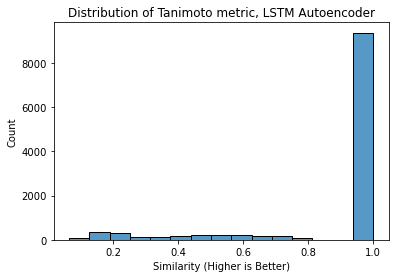

In [13]:
dist = tanimoto_dist(
    x_test.reshape(x_test.shape[0], data.shape[1], data.shape[2]), 
    autoencode_out_reshape, (data.shape[1], data.shape[2]), 
    selfies_alphabet)

sns.histplot(dist)
plt.title("Distribution of Tanimoto metric, LSTM Autoencoder")
plt.ylabel("Count")
plt.xlabel("Similarity (Higher is Better)")

(46546, 60, 30)
(46546, 60, 30)
Autoencoded Smiles: COC(=O)C1=C(Br)C(=O)C=CC1=O
True Smiles: COC(=O)C1=C(Br)C(=O)C=CC1=O
Percent Reconstructed Molescules: 0.9965410561594982


Text(0.5, 0, 'Similarity (Higher is Better)')

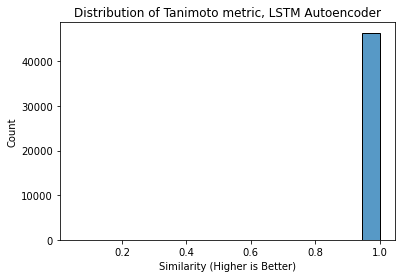

In [14]:
autoencode_out = sequence_autoencoder.predict(x_train)
autoencode_out_reshape = autoencode_out.reshape((len(x_train), data.shape[1], data.shape[2]))
################### AUTOENCODER TEST SCRIPTS - Full test script
print(np.shape(x_train.reshape(x_train.shape[0], data.shape[1], data.shape[2])))
print(np.shape(autoencode_out_reshape))
compare_equality(x_train.reshape(x_train.shape[0], data.shape[1], data.shape[2]), autoencode_out_reshape, 
                 (data.shape[1], data.shape[2]), selfies_alphabet)

dist = tanimoto_dist(
    x_train.reshape(x_train.shape[0], data.shape[1], data.shape[2]), 
    autoencode_out_reshape, (data.shape[1], data.shape[2]), 
    selfies_alphabet)

sns.histplot(dist)
plt.title("Distribution of Tanimoto metric, LSTM Autoencoder")
plt.ylabel("Count")
plt.xlabel("Similarity (Higher is Better)")

In [15]:
x_test_encoded = encoder.predict(x_test)
x_test_encoded_reshape = x_test_encoded.reshape(x_test_encoded.shape[0], x_test_encoded.shape[1] * x_test_encoded.shape[2])
x_train_encoded = encoder.predict(x_train)
x_train_encoded_reshape = x_train_encoded.reshape(x_train_encoded.shape[0], x_train_encoded.shape[1] * x_train_encoded.shape[2])

In [16]:
diff_train = diff[0:int(data.shape[0] * 0.8)]
diff_test = diff[int(data.shape[0] * 0.8):-1]
print(np.shape(x_test_encoded[0]))
print(np.shape(x_train_encoded[0]))
encode_dim = np.shape(x_test_encoded[0])
x_test_encoded = x_test_encoded.reshape(-1, encode_dim[0], encode_dim[1])
x_train_encoded = x_train_encoded.reshape(-1, encode_dim[0], encode_dim[1])

(60, 128)
(60, 128)


In [17]:
print(encode_dim[0], encode_dim[1])

60 128


In [18]:
from tensorflow.keras.models import Sequential

model = Sequential()

model.add(layers.Conv2D(filters=64, kernel_size=4, activation='relu', input_shape=(encode_dim[0], encode_dim[1],1),
                 strides=1, data_format="channels_last"))
model.add(layers.MaxPooling2D(pool_size=4))
model.add(layers.Conv2D(filters=32, kernel_size=4, activation='relu',
                 strides=1, data_format="channels_last"))
model.add(layers.MaxPooling2D(pool_size=6))
model.add(layers.Flatten())
model.add(layers.Dropout(0.25))
model.add(layers.Dense(1024, activation="relu"))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(1, activation="linear"))

model.summary()
model.compile(optimizer='adam', loss="MSE", metrics=["MeanSquaredError"])


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 57, 125, 64)       1088      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 31, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 28, 32)        32800     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 1, 4, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 128)               0         
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 1024)              1

In [20]:
hist = model.fit(np.array(x_train_encoded), scale(diff_train), epochs=50,
                validation_split=0.15)

Epoch 1/50


ValueError: in user code:

    /home/santiagovargas/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:806 train_function  *
        return step_function(self, iterator)
    /home/santiagovargas/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:796 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /home/santiagovargas/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /home/santiagovargas/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /home/santiagovargas/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    /home/santiagovargas/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:789 run_step  **
        outputs = model.train_step(data)
    /home/santiagovargas/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:747 train_step
        y_pred = self(x, training=True)
    /home/santiagovargas/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/tensorflow/python/keras/engine/base_layer.py:976 __call__
        self.name)
    /home/santiagovargas/anaconda3/envs/tf_gpu/lib/python3.7/site-packages/tensorflow/python/keras/engine/input_spec.py:196 assert_input_compatibility
        str(x.shape.as_list()))

    ValueError: Input 0 of layer sequential is incompatible with the layer: : expected min_ndim=4, found ndim=3. Full shape received: [None, 60, 128]


In [ ]:
print(hist.history)
plt.plot(hist.history["loss"])
plt.plot(hist.history["val_loss"])


In [ ]:
from sklearn.metrics import r2_score
y_test_pred = model.predict(np.array(x_test_encoded))
y_train_pred = model.predict(np.array(x_train_encoded))

print(r2_score(y_test_pred, diff_test))
print(r2_score(y_train_pred, diff_train))

# Sequential Models For Regression

In [26]:
# Try regressing with RNN, GRU, LTSM

model = keras.Sequential()
dims = np.shape(x_test_encoded)
print(dims)
#model.add(layers.Embedding(input_dim=dims[0], output_dim=dims[1])) input_dim=dims[0], output_dim=dims[1]
model.add(layers.LSTM(128, dropout = 0.25, input_shape = (dims[1], dims[2])))
model.add(layers.Dense(1))
model.summary()
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.002), 
        loss = "mse", metrics=[tf.keras.metrics.RootMeanSquaredError()])
history = model.fit(np.array(x_train_encoded), np.array(diff_train), 
                    epochs=50,  validation_split=0.15)


(11636, 60, 128)
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 129       
Total params: 131,713
Trainable params: 131,713
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
1237/1237 [==============================] - 4s 3ms/step - loss: 0.0087 - root_mean_squared_error: 0.0934 - val_loss: 7.4077e-05 - val_root_mean_squared_error: 0.0086
Epoch 2/50
1237/1237 [==============================] - 4s 3ms/step - loss: 1.2490e-04 - root_mean_squared_error: 0.0112 - val_loss: 1.1072e-04 - val_root_mean_squared_error: 0.0105
Epoch 3/50
1237/1237 [==============================] - 4s 3ms/step - loss: 1.2079e-04 - root_mean_squared_error: 0.0110 - val_loss: 

In [27]:
y_pred = model.predict(x_test_encoded)
y_pred_train = model.predict(x_train_encoded)
print(np.array(diff_test).shape)
print(y_pred.shape)
print(r2_score(np.array(y_pred), diff_test))
print(r2_score(np.array(y_pred_train), diff_train))

(11636,)
(11636, 1)
0.05870085839502204
0.541241126143472


In [210]:
#for i in range(np.array(y_pred).shape[0]):
#    print(np.array(y_pred_train[i,-1]))


In [ ]:
from sklearn.metrics import r2_score
#y_test_pred = model.predict(np.array(x_test_encoded))
#y_train_pred = model.predict(np.array(x_train_encoded_reshape))

print(r2_score(y_pred, diff_test))
#print(r2_score(y_train_pred, diff_train))

In [ ]:


model = keras.Sequential()
dims = np.shape(x_test_encoded)
print(dims)
#model.add(layers.Embedding(input_dim=dims[0], output_dim=dims[1])) input_dim=dims[0], output_dim=dims[1]
model.add(layers.SimpleRNN(128, input_shape = (dims[1], dims[2])))
model.add(layers.Dense(1))
model.summary()
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), 
        loss = "mse", metrics=[tf.keras.metrics.RootMeanSquaredError()])
history = model.fit(np.array(x_train_encoded), np.array(diff_train), 
                    epochs=30,  validation_split=0.15)


In [ ]:
y_pred = model.predict(x_test_encoded)
y_pred_train = model.predict(x_train_encoded)
print(np.array(diff_test).shape)
print(y_pred.shape)
print(r2_score(np.array(y_pred), diff_test))
print(r2_score(np.array(y_pred_train), diff_train))

In [38]:

model = keras.Sequential()
dims = np.shape(x_test_encoded)
print(dims)
#model.add(layers.Embedding(input_dim=dims[0], output_dim=dims[1])) input_dim=dims[0], output_dim=dims[1]
model.add(layers.GRU(64, dropout = 0.1, return_sequences= True, input_shape = (dims[1], dims[2])))
model.add(layers.GRU(64, dropout = 0.1))
model.add(layers.Dense(1))
model.summary()
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.002), 
        loss = "mse", metrics=[tf.keras.metrics.RootMeanSquaredError()])
history = model.fit(np.array(x_train_encoded), np.array(diff_train), 
                    epochs=25,  validation_split=0.20)


(11636, 60, 128)
Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_8 (GRU)                  (None, 60, 64)            37248     
_________________________________________________________________
gru_9 (GRU)                  (None, 64)                24960     
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 65        
Total params: 62,273
Trainable params: 62,273
Non-trainable params: 0
_________________________________________________________________
Epoch 1/25
1164/1164 [==============================] - 6s 5ms/step - loss: 0.0191 - root_mean_squared_error: 0.1383 - val_loss: 2.9512e-04 - val_root_mean_squared_error: 0.0172
Epoch 2/25
1164/1164 [==============================] - 5s 4ms/step - loss: 1.2882e-04 - root_mean_squared_error: 0.0113 - val_loss: 4.6086e-05 - val_root_mean_squared_error: 0.0068
Ep

In [39]:
y_pred = model.predict(x_test_encoded)
y_pred_train = model.predict(x_train_encoded)
print(np.array(diff_test).shape)
print(y_pred.shape)
print(r2_score(np.array(y_pred), diff_test))
print(r2_score(np.array(y_pred_train), diff_train))

(11636,)
(11636, 1)
-0.9663915027740837
-0.29776339864565315
